#**M6 Wisconsin Breast Cancer Dataset**



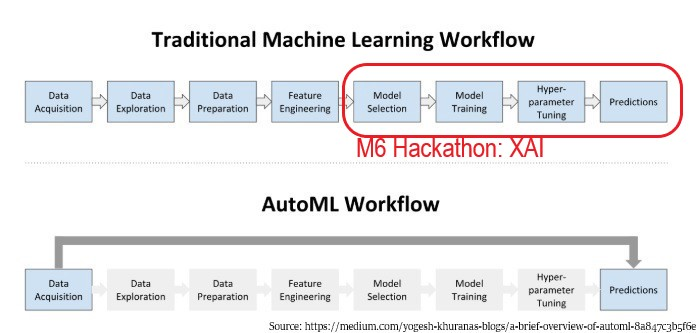

Explainability and interpretability are often used interchangeably:
* Interpretability is the degree to which a human can understand the cause of a decision or the degree to which a human can consistently predict ML model results - Christoph Molnar
* Explainability in machine learning means that you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem.


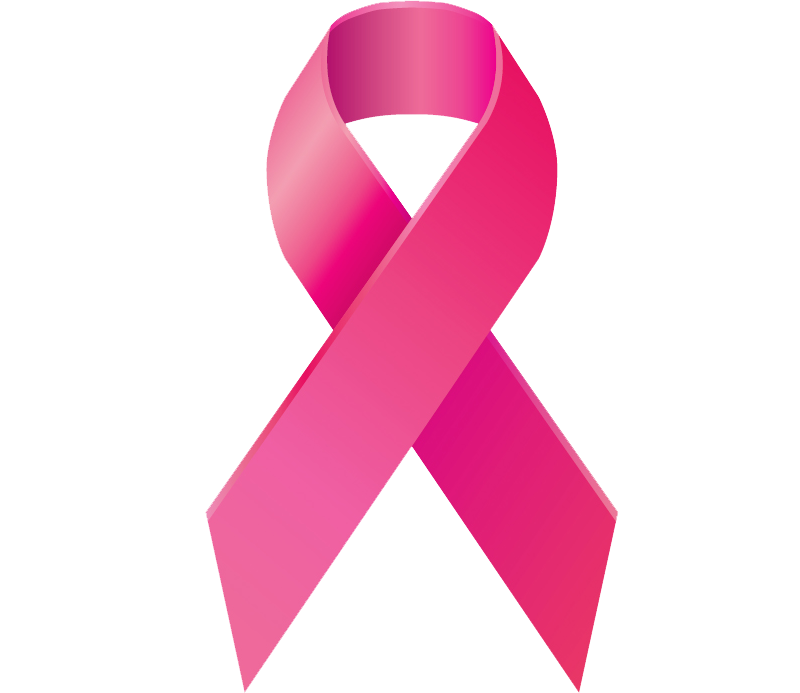

#**Table of Contents**
* Executive Summary (BLUF)
* Business Problem
* Conclusions from Data Preprocessing & Classification Notebooks
* Libraries
* Data
* Predictors & Target Variable
* Skewness Correction
* Outliers
* SMOTE & Scaling
* Random Forest Model
  * Global Methods
    * Permutation Importance
    * Feature Importance Using Random Forest
    * Feature Importance Using XGBoosgt Model
    * SHAP Values (Global)
    * KDE Plots
    * Partial Dependence Plots
    * Surrogate Models (Global)   
  * Local Methods
    * SHAP Values (Local)
    * LIME
    * Individual Conditional Expectation (ICE) Plots
* Conclusions

#**Executive Summary (BLUF)**
Explainability analysis for a high quality random forest classifier shows consistency in feature importance using permutation and Shapley value analysis. KDE plots, local Shapley value analysis, and partial dependence plots show that, in general, higher values of all features are ominous, and point to malignancy.

Overall, results are very promising. If the explanations hold up on a larger dataset, their automated use in annotating mammograms and other clinical applications can be explored.

#**Business Problem**
A random forest model that was developed (with AUC mean of 0.992, mean recall of 0.928, and mean accuracy of 0.973) to predict breast cancer is being explored for adoption across a multi-state multi-hospital group. The group's Chief Risk Officer (CRO) wants an explanation of how the model works, and additionally wants to develop technology to support doctors in explaining the reasons for their diagnosis to patients (individually).


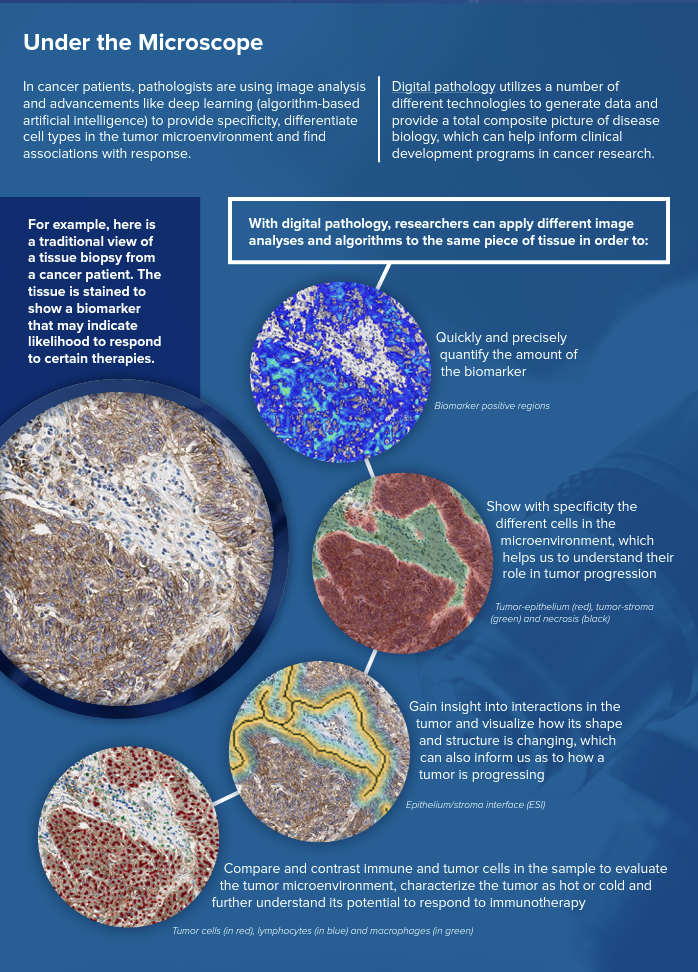

#**Conclusions from the Preprocessing & Classification Notebooks**
*Data Preprocessing*
- No missing value or duplicate pre-processing needed
- Corrected for skewness
- Winsorized outliers in order to preserve data
- Two to three principal components may be sufficient to build a satisfactory model
- The data set is unbalanced (37.26% of the instances are for malignant masses). We can try building the models using the unbalanced data, or we can try SMOTE. There is likely too little data to contemplate undersampling. 

*Classification*
* Several models with AUC above 99% and recall above 95% were obtained. A random forest model was developed with AUC mean of 0.992, mean recall of 0.928, and mean accuracy of 0.73. 
* A logistic regression model provided similar performance.
* We did not test the possibility that outliers (that we deleted) may end up actually helping our model. PCA and SMOTE offer small improvements. Techniques that seek better models for hard-to-classify instances may be needed to squeeze out FNs.

#**Libraries**

In [ ]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math
from matplotlib.colors import ListedColormap

In [ ]:
# LightGBM Library
!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
# sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [ ]:
# mblearn library
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

In [ ]:
!pip install shap
import shap

In [ ]:
!pip install lime
import lime
import lime.lime_tabular

In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

#**Data**

In [ ]:
# Read in data from the sklearn library
cancer = load_breast_cancer()

# Column 1 is the target (1=malignant, 0 = benign)
# Note that np.c_ translates slice objects to concatenation along the second axis
df = pd.DataFrame(np.c_[cancer['target'],cancer['data']], columns = np.append(['target'],cancer['feature_names']))
# Plot the last 5 rows of the data
df.tail()

,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
564,0.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,1.0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


#**Predictors & Target Variable**


In [ ]:
# Create binary-encoded target column (y)
from sklearn import preprocessing
y = df[['target']]
y = pd.get_dummies(data=y,columns=['target'],drop_first=True)

#Drop ID and old target column to get predictors (X)
X = df.drop(columns=['target'])
feature_names = X.columns
df = pd.concat([y,X],axis=1)

#**Skewness Correction**

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""

"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness



def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(X.copy(deep=True), plot = False, exp = False, threshold = 1)

#**Outliers**

In [ ]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  
# Windsorize X and check the results
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))

#**SMOTE & Scaling**





In [ ]:
# We will use the entire dataset for explainability (i.e., no split into training and test sets)
# SMOTE The data
sm = SMOTE()
X_SMOTE, y_SMOTE = sm.fit_resample(X_winsorized, y)

# Standardize the predictors
stdsc = StandardScaler()  
X_SMOTE_std = pd.DataFrame(stdsc.fit_transform(X_SMOTE))

#**Random Forest Model**
This is the model that we wish to explain!

In [ ]:
# Spawn instance of random forest classifier, parametrized according to the gridseracgh in the classification notebook 
clf = RandomForestClassifier(oob_score=True,class_weight= {0: 0.2, 1: 0.8}, criterion='gini',max_depth=7)

# Fit Random Forest model
clf.fit(X_SMOTE_std,np.ravel(y_SMOTE))

# Capture predictons using Random Forest classifier
y_pred = clf.predict(X_SMOTE_std)
y_pred = pd.DataFrame(y_pred)

# Capture feature names
X_SMOTE_std.columns = cols

##**Global Methods**

###*Permutation Importance*

Text(0.5, 0, 'Permutation Importance')

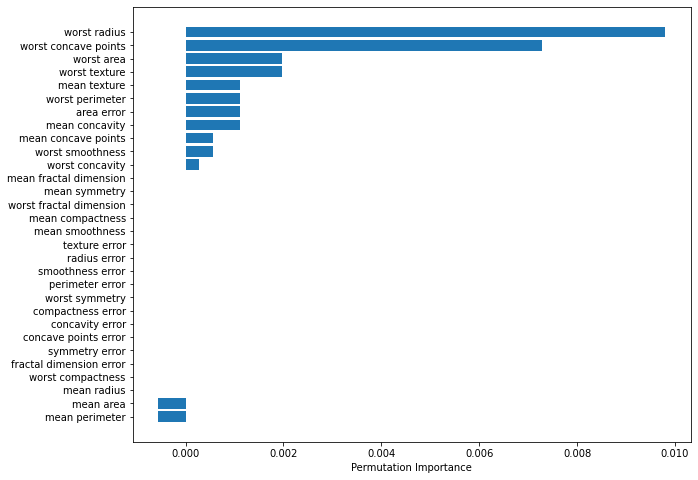

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
perm_importance = permutation_importance(clf, X_SMOTE_std, y_SMOTE)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(cols[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

###*Feature Importance Using Random Forest Model*
Some code adapted from here: https://www.kaggle.com/paultimothymooney/feature-selection-with-permutation-importance

Text(0.5, 0, 'Random Forest Model Feature Importance')

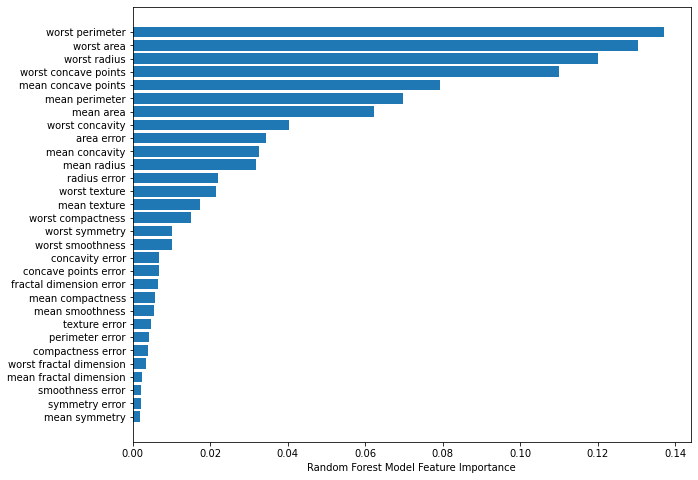

In [ ]:
# Fit Random Forest model, recover feature importances
clf.fit(X_SMOTE_std,np.ravel(y_SMOTE))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(cols[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Model Feature Importance")

###*Feature Importance Using XGBoost Model*

Text(0.5, 0, 'XGBoost Model Feature Importance')

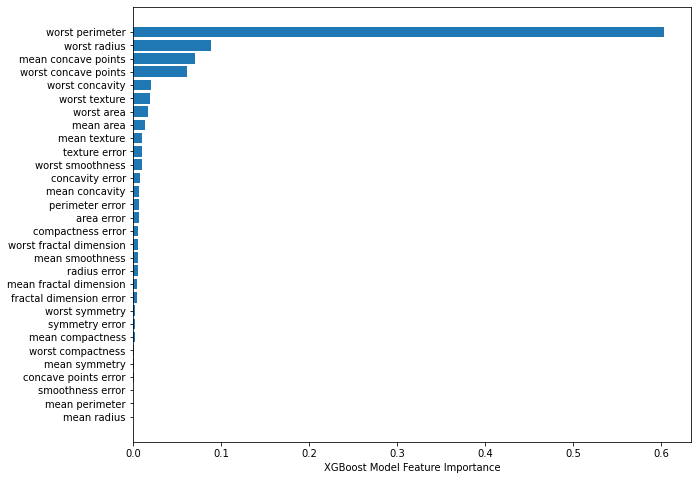

In [ ]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_SMOTE_std, np.ravel(y_SMOTE))
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(cols[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Model Feature Importance")

###*Shapley values (Global)*
This is an alternative to feature importance analysis. Pros of SHAP values:
* Global interpretability: SHAP values show magnitude and direction of feature importance for a model.
* Local interpretability: SHAP values show magnitude and direction of feature importance for an instance.
* Applicable to a wide variety of models.

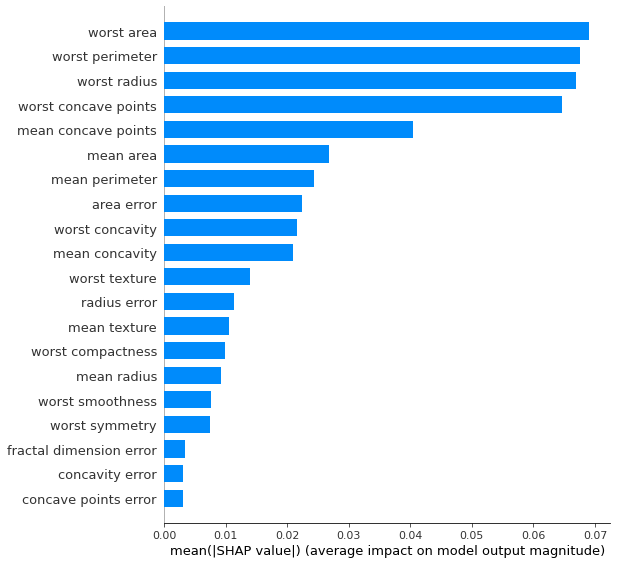

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_SMOTE_std)
shap.summary_plot(shap_values[1], X_SMOTE_std, plot_type='bar',feature_names=cols)

###*KDE Plots*
These allow us to understand the distribution of the malignant and benign instances for the most important features.




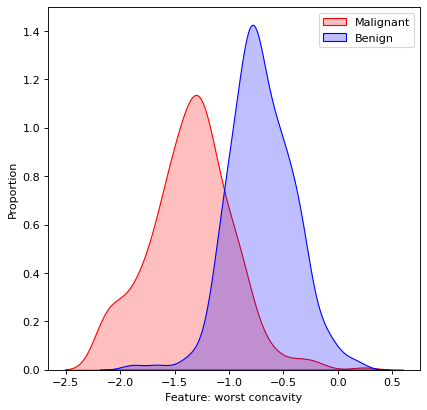

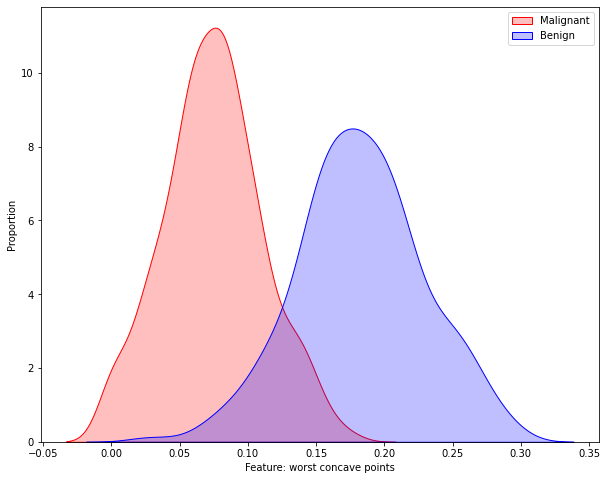

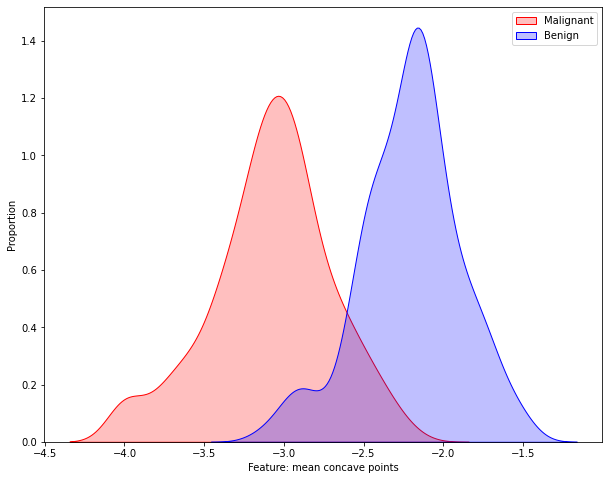

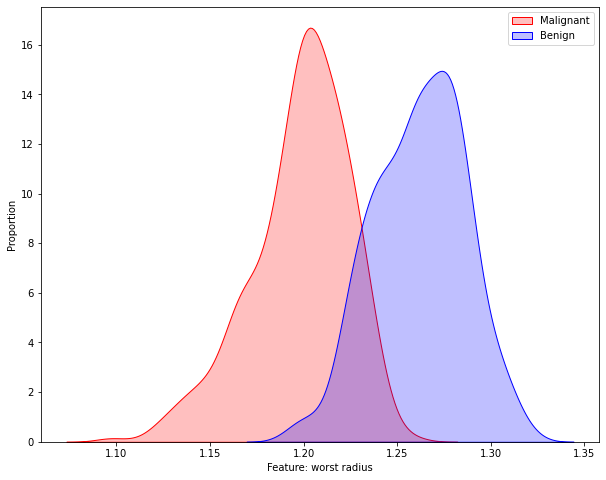

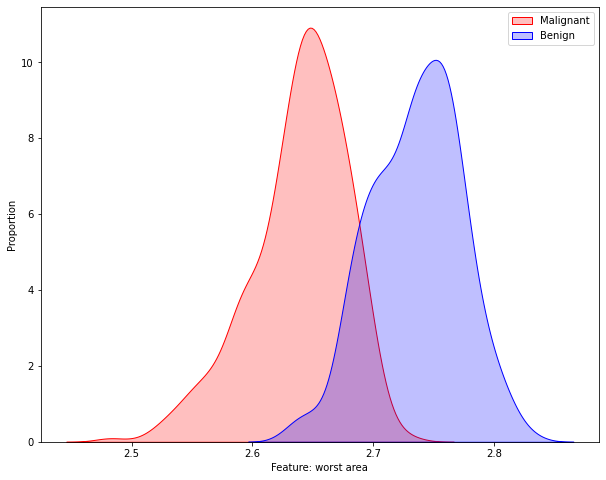

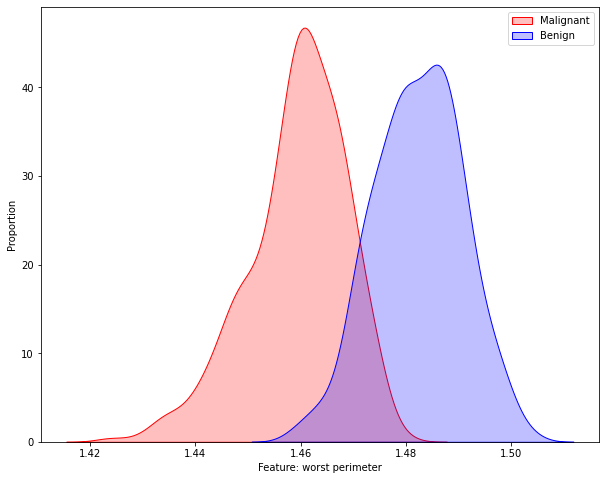

In [ ]:
# Generate kde plots to examine the density functions of the most important features
# Note: the kde plots present X, before SMOTE and standardzizaton, as that is what a domain expert will best be able to consume.
# Note: there is an implementation problem in the code below: I should be using the predicted values for the target, rather than the actual values.
from matplotlib.pyplot import figure
figure(figsize=(6, 6), dpi=80)
df=pd.concat([y,X],axis=1)
for i in ['worst concavity', 'worst concave points', 'mean concave points', 'worst radius', 'worst area', 'worst perimeter']:
    sns.kdeplot(df.loc[(df['target_1.0']==1),i], color='red', shade=True, Label='Malignant')
    sns.kdeplot(df.loc[(df['target_1.0']==0),i], color='blue', shade=True, Label='Benign')
    plt.xlabel('Feature: '+str(i))
    plt.ylabel('Proportion')   
    plt.legend(loc='upper right')
    plt.show()
    

Inference: notice how the larger values for each of these features point to malignancy, consistent with our local SHAP values analysis.

###*Partial Dependence Plots*

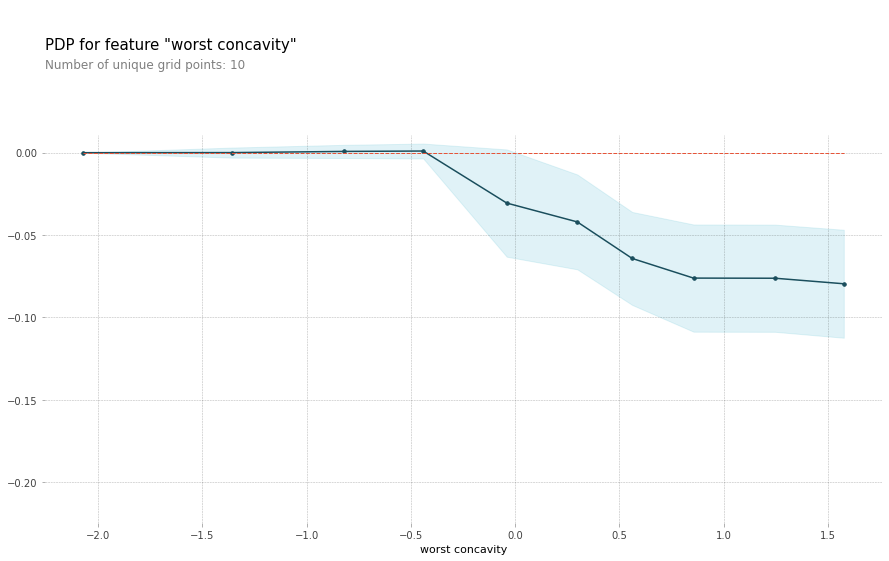

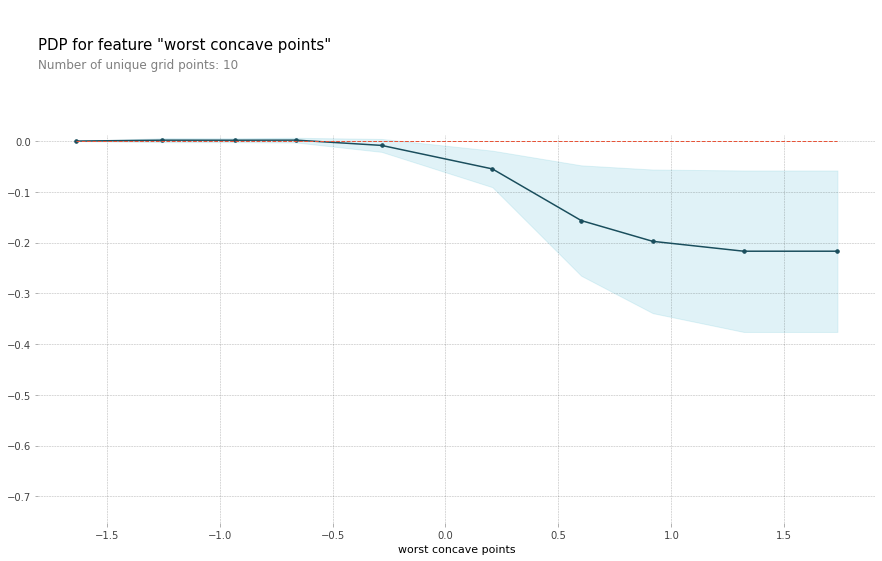

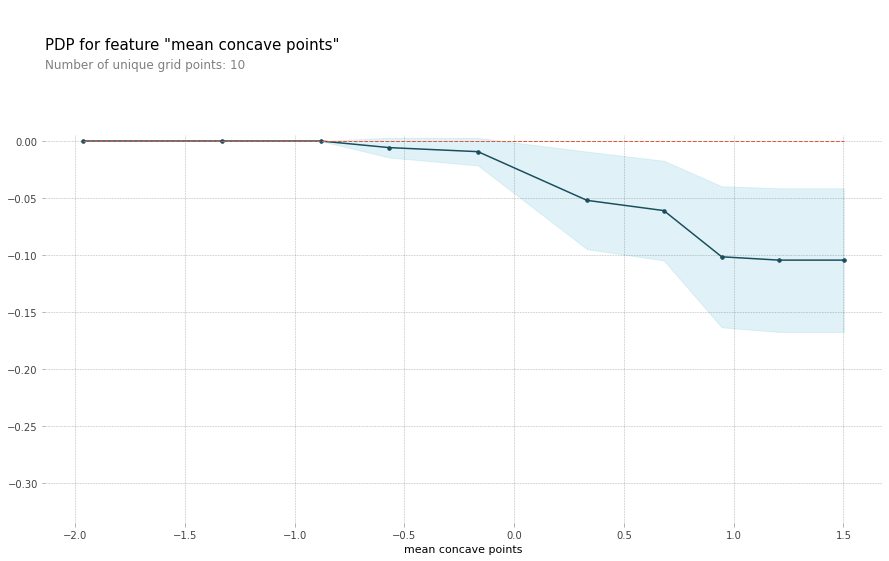

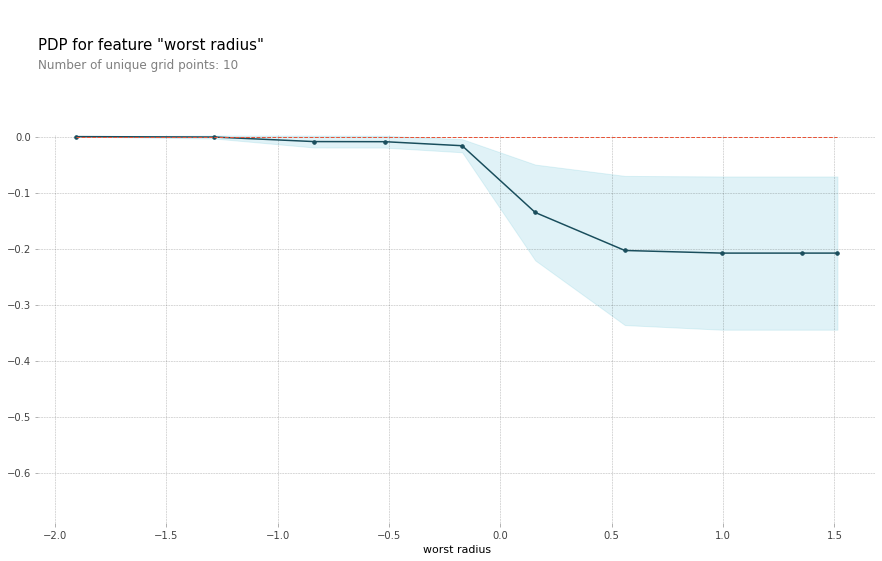

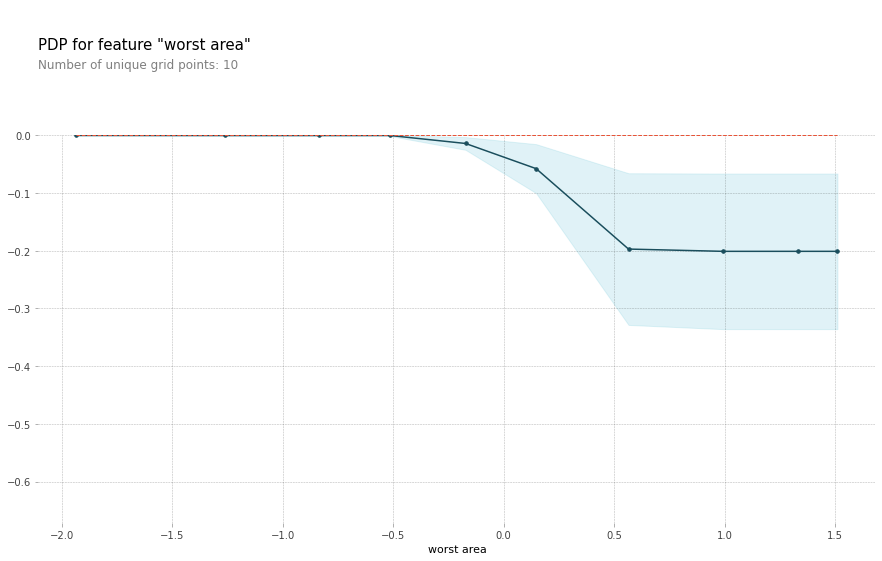

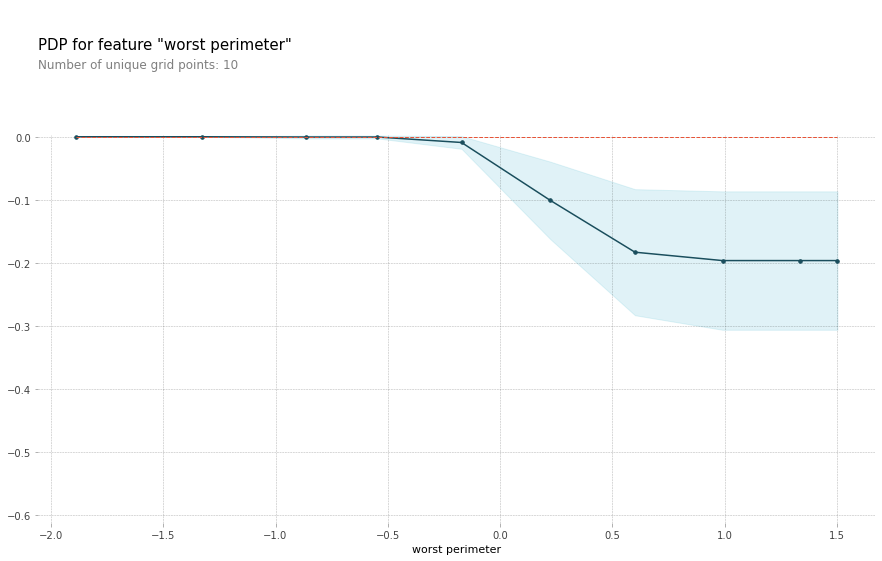

In [ ]:

# Univariate Partial Dependence Plot
for i in ['worst concavity', 'worst concave points', 'mean concave points', 'worst radius', 'worst area', 'worst perimeter']:    
    pdp_ = pdp.pdp_isolate(model = clf, dataset = X_SMOTE_std, model_features=cols, feature = i)
    pdp.pdp_plot(pdp_, str(i))
    plt.show()

So, for example, the partial dependence plot for worst perimeter indicates that a value less than -0.1 strongly suggests a mass is benign, whereas a value greater than 0.2, strongly suggests malignancy. Both values are on the standardized scale.  

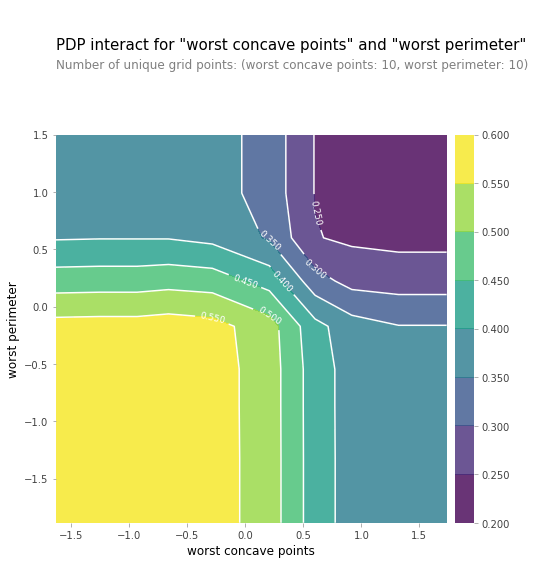

In [ ]:
# Bivariate PDP
# Similar to previous PDP plots except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['worst concave points', 'worst perimeter']
inter1  =  pdp.pdp_interact(model=clf, dataset=X_SMOTE_std, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

The bivariate (2D) PDP strongly suggests that malignancy is correlated with both worst perimeter and worst concave points, and this conclusion is confirmed by the correlation matrix (both correlations are around 0.8).  

###*Surrogate Models (Global)*

The same features are identified as most important using feature importance and Shapley values, but the six features do not have the same rank order using the two methods.

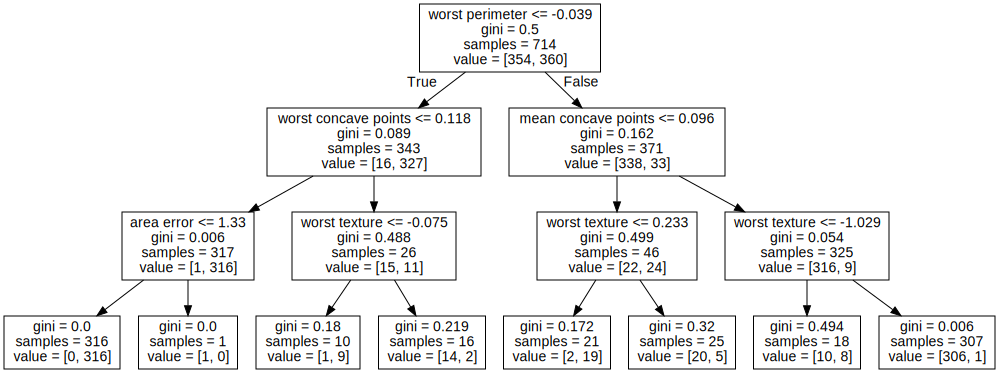

In [ ]:
# Decision Tree surrogate model of Random Forest model
from sklearn import tree
import graphviz

proxy = DecisionTreeClassifier(random_state = 20850,max_depth=3)    # Control the depth of the proxy tree here
proxy.fit(X_SMOTE_std,y_pred)

tree_graph = tree.export_graphviz(proxy, out_file = None, feature_names = cols)
graphviz.Source(tree_graph)

The decision tree can be used to extract rules for identifying benign masses:
* If 'worst perimeter <= x and 'worst concave points' <= y OR
* If 'worst perimeter' > x and 'mean_concave_points' <= z
then the mass is benign. These rules are a proxy for the classifications produced by the random forest.

In [ ]:
# How good is this surrogate decision tree model? 
# Let's find out by computing the correlation between the predictions of the original model and the surrogate model
y_proxy = proxy.predict(X_SMOTE_std) # Use the decision tree to make predictions
y_proxy = pd.DataFrame(y_proxy)
print('Correlation coefficient of RF predictions and Surrogate Model predictions: ',y_pred.corrwith(y_proxy,axis=0))

Correlation coefficient of RF predictions and Surrogate Model predictions:  0    0.947419
dtype: float64


##**Local Methods**

###*Shapley values (Local)*
This area is still under construction

In [ ]:
# @app.route("/")
# def home():
#     return "<h1>GFG is great platform to learn</h1>"
    
# app.run()

In [ ]:
# # We'll use shapash to generate local Shapley values
# from shapash.explainer.smart_explainer import SmartExplainer
# xpl = SmartExplainer()
# xpl.compile(
#     x=X_SMOTE_std,
#     model=clf,
# #    y_pred=y_pred
# )

In [ ]:
# app = xpl.run_app()
# !ngrok authtoken 27MAdoh3QCvpRAnOszsvIH3FL2z_83ZJTfAyVNK4m9GUDvsBu

In [ ]:
# # Check direction of impact (local Shapley values)
# shap.summary_plot(shap_values[1], X_SMOTE_std,feature_names=Xcols)

We can see the distribution of instances here, for the most important features. The malignant instances are shown in red. Notice that the malignant instances mostly have SHAP values higher than benign instances across nearly all features.

###*LIME*
LIME, the abbreviation for **L**ocal **I**nterpretable **M**odel-agnostic **E**xplanations, is a technique that approximates any black box machine learning model with a local, interpretable model to explain each instance.

Area under construction

###*Individual Conditional Expectation (ICE) Plots*
An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot. 

Computing partial dependence plots...


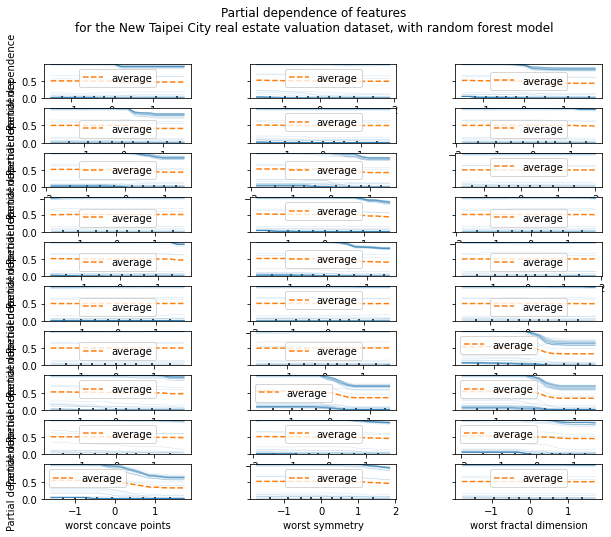

In [ ]:
# Create ICE plots
!pip install scikit-learn --upgrade
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
print("Computing partial dependence plots...")

display = PartialDependenceDisplay.from_estimator(
    clf,
    X_SMOTE_std,
    features=cols,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)

display.figure_.suptitle(
      "Partial dependence of features\n"
    "for the New Taipei City real estate valuation dataset, with random forest model"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

#**Conclusion**

We identified ['worst concavity', 'worst concave points', 'mean concave points', 'worst radius', 'worst area', 'worst perimeter'] as the most important features of the random forest model using both permutation feature importance and global Shapley value analysis. 

Using KDE plot and partial dependence plots, we are able to identify key values of each of the most important features below which, the model indicates, on average, that a mass is benign. In general we can see from the local Shapley value plot, the KDE plots, and the partial dependence plots, that larger values of most of the features suggest malignancy (and this is line with the clinical meaning of the features, AFAIK).

LIME can be used to provide a detailed explanation at the instance level. Notice that all explanations use the standardized, and not the original feature scales.

The decision tree proxy model (for some levels of tree depth) uses features other than the most important ones identified using Shapley or permutation feature importance analysis. This is something of an anomaly that needs to be explored.

The ICE plots show good separation of the instances by feature value.

Overall, results are very promising. We have powerful classifiers, and if the explanations hold up on a larger dataset, their automated use in annotating mammograms and other clinical applications can be explored.
